# Using Interval Variables and AddNoOverlap2D constraint for 2D rectangle packing

Given a rectangular container and a set of rectangular items, the goal is to pack all items into the container respecting the orientation of items.
All rectangles are orthogonal, i.e. they are parallel to the axes of the container.
Thus, each item is defined by its length and width.

This problem is also known as the 2D bin packing problem and is NP-hard.
With CP-SAT, we can easily model this problem and solve smaller instances to optimality.

In [2]:
from ortools.sat.python import cp_model

In [23]:
# Instance
container = (40, 15, 15)
boxes = [
    (11, 3, 4),
    (13, 3, 2),
    (9, 2, 4),
    (7, 2, 6),
    (9, 3, 1),
    (7, 3, 3),
    (11, 2, 3),
    (13, 2, 2),
    (11, 4, 7),
    (13, 4, 6),
    (3, 5, 1),
    (11, 2, 2),
    (2, 2, 3),
    (11, 3, 4),
    (2, 3, 5),
    (5, 4, 5),
    (6, 4, 4),
    (12, 2, 3),
    (1, 2, 2),
    (3, 5, 3),
    (13, 5, 1),
    (12, 4, 4),
    (1, 4, 1),
    (5, 2, 3),
    (6,  2, 1),  # add to make tight
    #(6,3, 1), # add to make infeasible
]

In [24]:
model = cp_model.CpModel()

In [25]:
# We have to create the variable for the bottom left corner of the boxes.
# We directly limit their range, such that the boxes are inside the container
x_vars = [
    model.NewIntVar(0, container[0] - box[0], name=f"x1_{i}")
    for i, box in enumerate(boxes)
]
y_vars = [
    model.NewIntVar(0, container[1] - box[1], name=f"y1_{i}")
    for i, box in enumerate(boxes)
]

# Interval variables are actually more like constraint containers, that are then passed to the no overlap constraint
# Note that we could also make size and end variables, but we don't need them here
x_interval_vars = [
    model.NewIntervalVar(
        start=x_vars[i], size=box[0], end=x_vars[i] + box[0], name=f"x_interval_{i}"
    )
    for i, box in enumerate(boxes)
]
y_interval_vars = [
    model.NewIntervalVar(
        start=y_vars[i], size=box[1], end=y_vars[i] + box[1], name=f"y_interval_{i}"
    )
    for i, box in enumerate(boxes)
]
# Enforce that no two rectangles overlap
model.AddNoOverlap2D(x_interval_vars, y_interval_vars)

In [26]:
z_vars = [
    model.NewIntVar(0, 1, name=f"z1_{i}")
    for i, box in enumerate(boxes)
]
model.Add(sum(z_vars[i] * boxes[i][2] for i in range(len(boxes))) <= container[2])

In [27]:
box_areas = [box[0]*box[1] for box in boxes]
objective = sum(z_vars[i] * box_areas[i] for i in range(len(boxes)))
model.Maximize(objective)

In [28]:
# Solve!
solver = cp_model.CpSolver()
solver.parameters.log_search_progress = True
solver.log_callback = print
status = solver.Solve(model)
assert status == cp_model.OPTIMAL
for i, box in enumerate(boxes):
    print(
        f"box {i} is placed at ({solver.Value(x_vars[i])}, {solver.Value(y_vars[i])})"
    )


Starting CP-SAT solver v9.8.3296
Parameters: log_search_progress: true
Setting number of workers to 8


Starting CP-SAT solver v9.8.3296
Parameters: log_search_progress: true
Setting number of workers to 8

Initial optimization model '': (model_fingerprint: 0x2633c7ba6884952e)
#Variables: 75 (#bools: 25 in objective)
  - 25 Booleans in [0,1]
  - 3 in [0,10]
  - 6 in [0,11]
  - 6 in [0,12]
  - 10 in [0,13]
  - 4 in [0,27]
  - 2 in [0,28]
  - 5 in [0,29]
  - 2 in [0,31]
  - 2 in [0,33]
  - 2 in [0,34]
  - 2 in [0,35]
  - 2 in [0,37]
  - 2 in [0,38]
  - 2 in [0,39]
#kInterval: 50
#kLinear1: 50
#kLinearN: 1 (#terms: 25)
#kNoOverlap2D: 1 (#rectangles: 25)
Initial optimization model '': (model_fingerprint: 0x2633c7ba6884952e)
#Variables: 75 (#bools: 25 in objective)
  - 25 Booleans in [0,1]
  - 3 in [0,10]
  - 6 in [0,11]
  - 6 in [0,12]
  - 10 in [0,13]
  - 4 in [0,27]
  - 2 in [0,28]
  - 5 in [0,29]
  - 2 in [0,31]
  - 2 in [0,33]
  - 2 in [0,34]
  - 2 in [0,35]
  - 2 in [0,37]
  - 2 in [

In [29]:
for i in range(len(z_vars)):
    print(f"z_{i} = {solver.Value(z_vars[i])}")

z_0 = 0
z_1 = 1
z_2 = 0
z_3 = 0
z_4 = 1
z_5 = 0
z_6 = 0
z_7 = 1
z_8 = 0
z_9 = 0
z_10 = 1
z_11 = 1
z_12 = 0
z_13 = 0
z_14 = 0
z_15 = 0
z_16 = 0
z_17 = 0
z_18 = 0
z_19 = 0
z_20 = 1
z_21 = 1
z_22 = 1
z_23 = 0
z_24 = 1


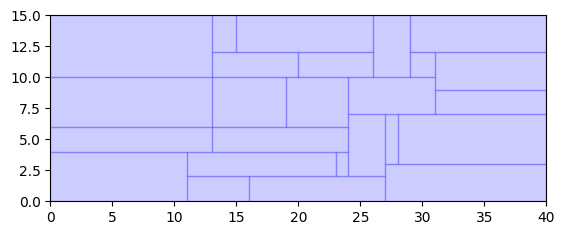

In [31]:
# plot the solution
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1)
ax.set_xlim(0, container[0])
ax.set_ylim(0, container[1])
for i, box in enumerate(boxes):
    #if solver.Value(z_vars[i]) > 0:
    ax.add_patch(
        patches.Rectangle(
            (solver.Value(x_vars[i]), solver.Value(y_vars[i])),
            box[0],
            box[1],
            facecolor="blue",
            alpha=0.2,
            edgecolor="b",
        )
    )
# uniform axis
ax.set_aspect("equal", adjustable="box")
plt.show()